In [1]:
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from swissgrid import grid_data as gd
import numpy as np
from sklearn.linear_model import LinearRegression

In [225]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import api as sm

In [5]:
total_consumption = gd.iloc[:,2]

In [6]:
consw = total_consumption.resample('W').sum()[1:-1] #discard first and last because incomplete

In [7]:
weather = pd.read_csv('../../weather_data_filtered.csv')
weather['timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather = weather[['timestamp', 'CH_temperature']].set_index('timestamp').sort_index()
weather = weather.tz_localize(None)

#align weather and consumption indexes
w = weather.resample('W').mean()[consw.index[0]:]
c = consw[:w.index[-1]]/1e6 #unit of measurement is now GWh

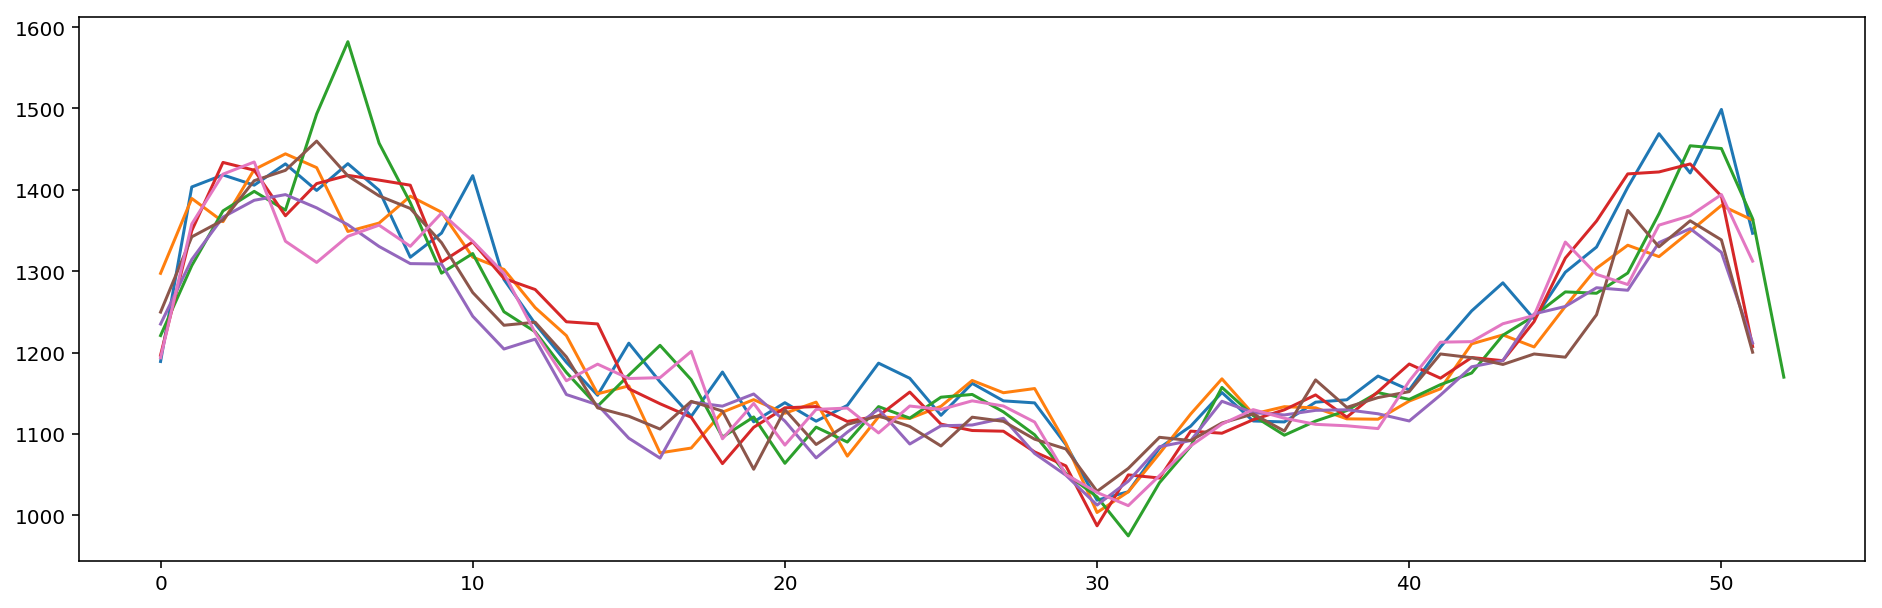

In [8]:
[plt.plot(c[str(year)].values) for year in range(2010,2017)];

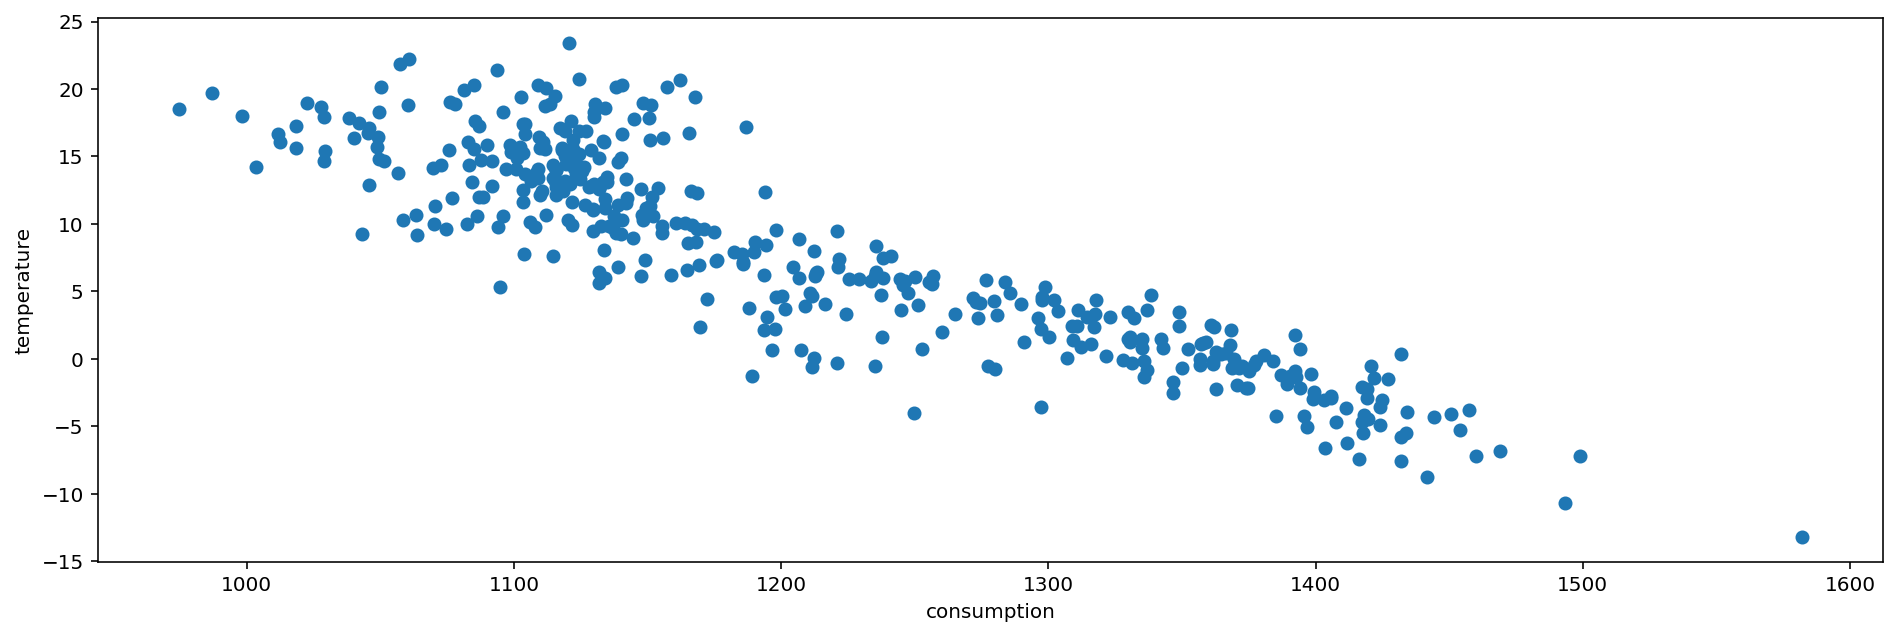

In [9]:
plt.scatter(c, w)
plt.xlabel('consumption')
plt.ylabel('temperature');

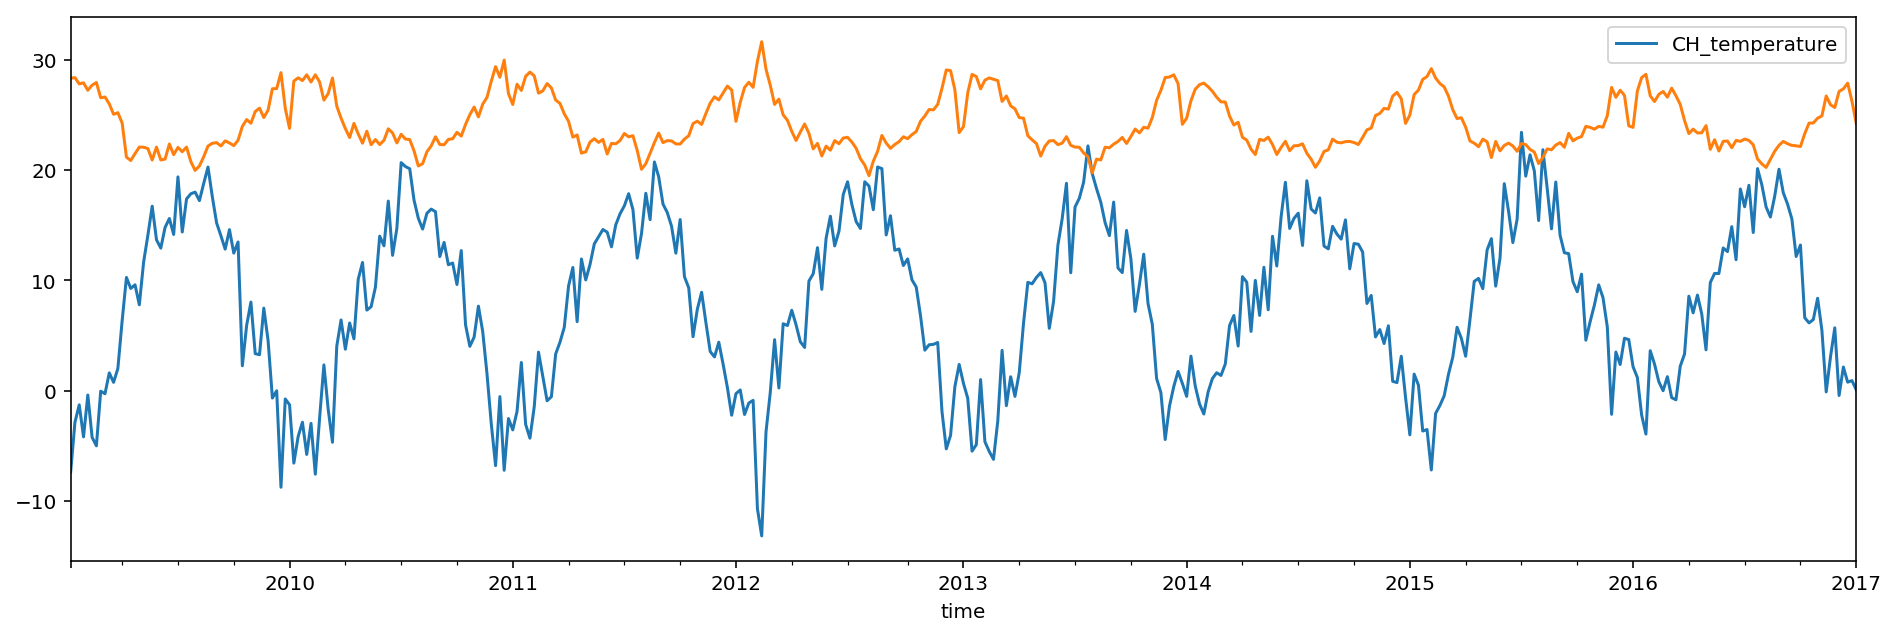

In [10]:
w.plot()
(c/50).plot()

In [11]:
weather_model = LinearRegression().fit(w.values.reshape(-1,1), c.values.reshape(-1,1))

In [12]:
est_weather = pd.Series(data=weather_model.predict(w.values.reshape(-1,1)).flatten(), index=w.index)

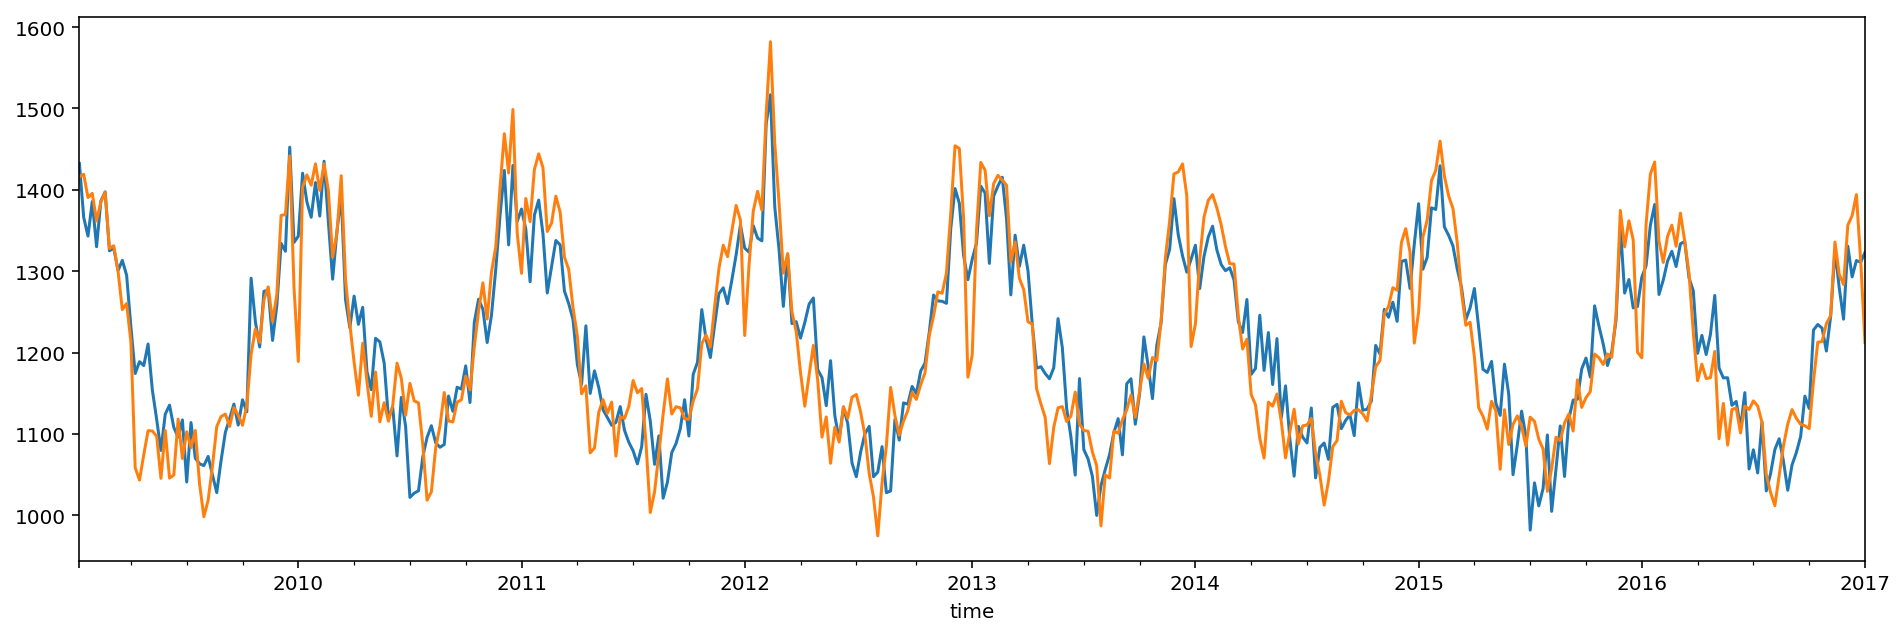

In [13]:
est_weather.plot()
c.plot()

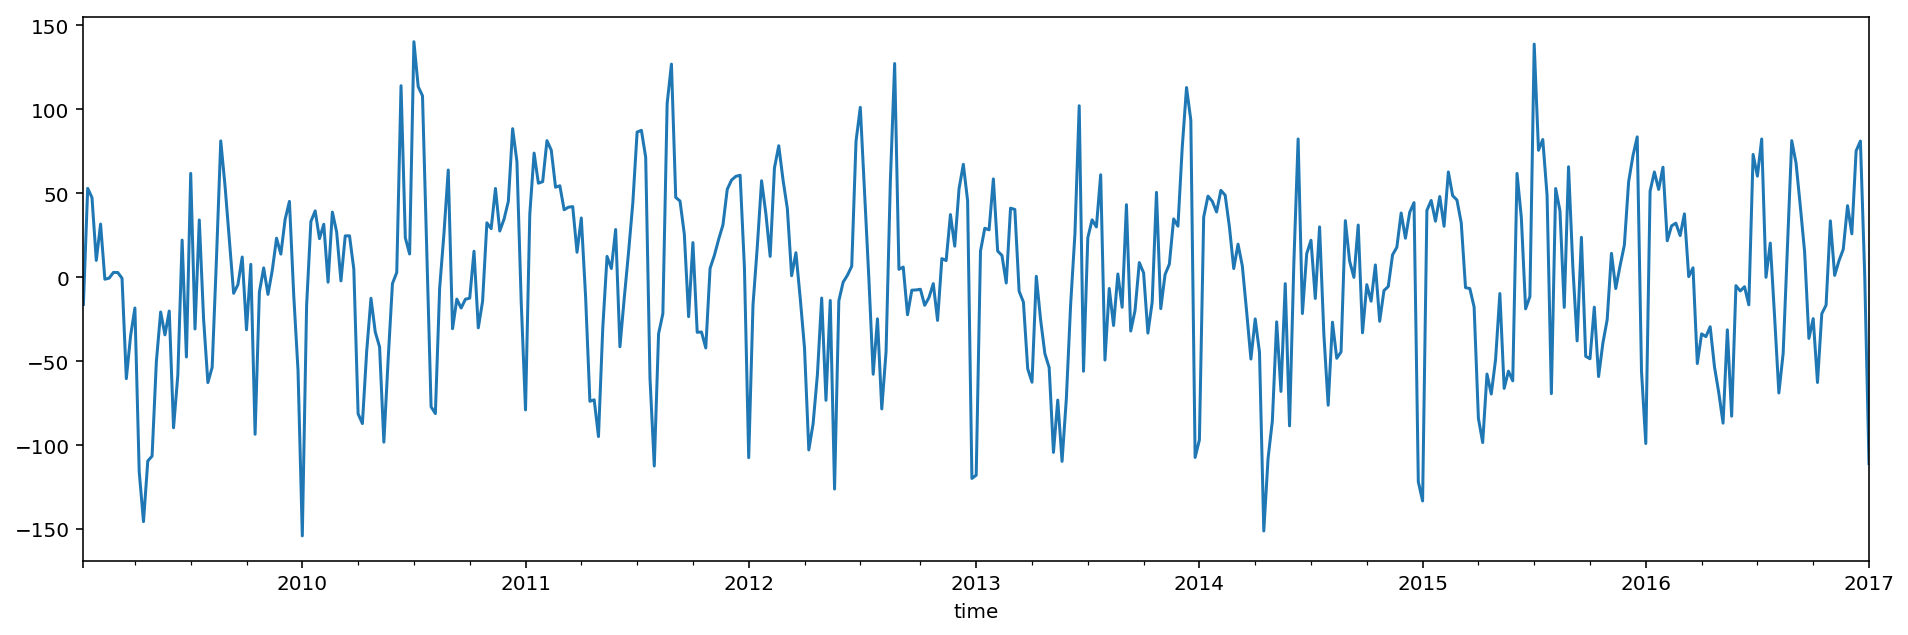

In [14]:
residual_weather = c - est_weather
residual_weather.plot()

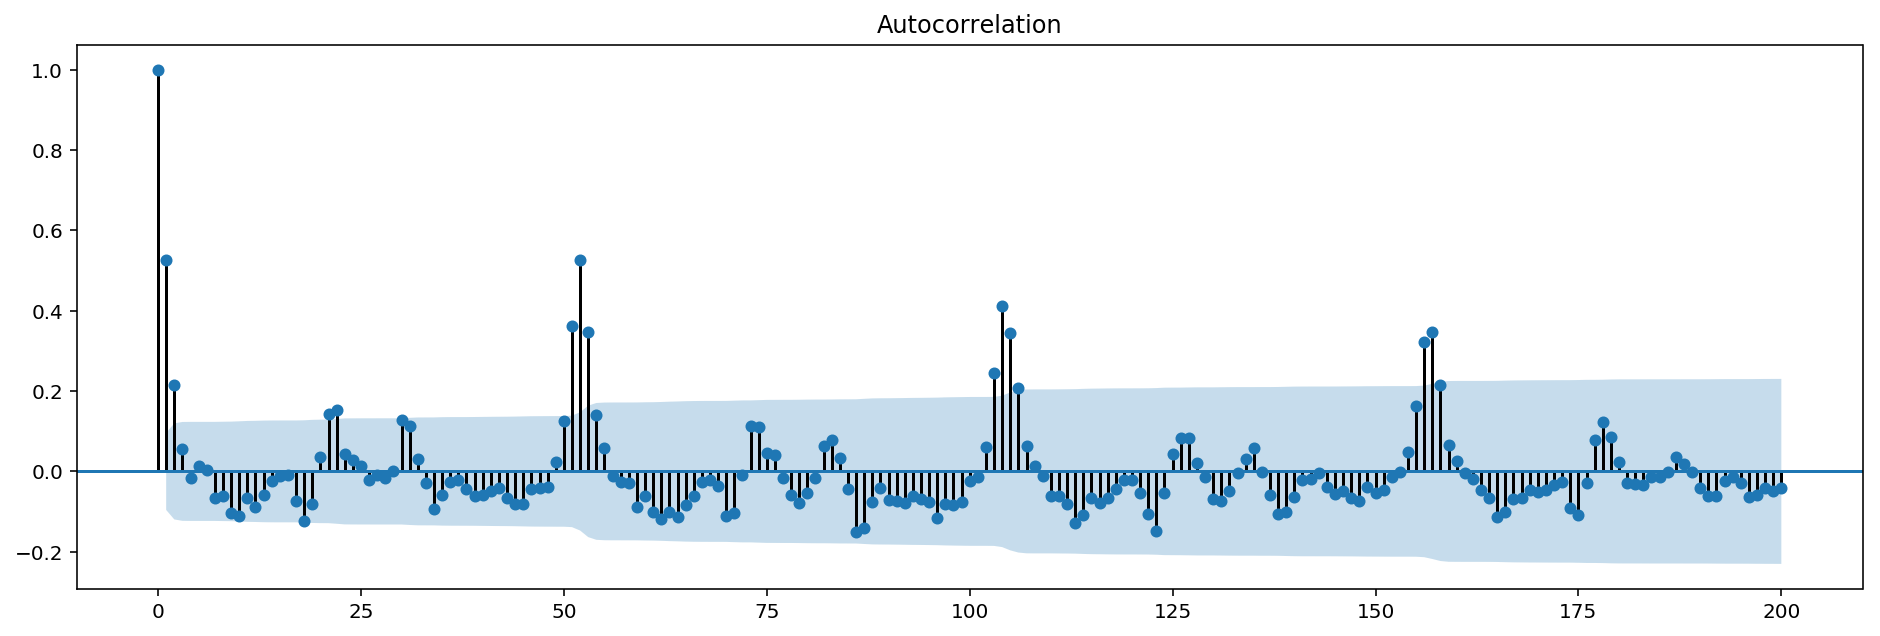

In [226]:
plot_acf(residual_weather,lags=200);

# Introducing Holidays covariates

In [16]:
import holidays

In [17]:
holidays_ch = holidays.Switzerland()
days = total_consumption.resample('D').sum().index
is_holy = [day in holidays_ch for day in days]
holys = pd.DataFrame(is_holy, days, columns=['is_holiday'])

# regress residuals on additional variable which counts the swiss festivities per week
h_reg = (holys['is_holiday']*1).resample('W').sum()[residual_weather.index[0]:residual_weather.index[-1]]

In [18]:
holiday_crude_model = LinearRegression().fit(h_reg.values.reshape(-1,1), residual_weather.values.reshape(-1,1))

In [19]:
est_holiday_crude = pd.Series(data=holiday_crude_model.predict(h_reg.values[...,None]).flatten(), index=h_reg.index)
res_holiday_crude = (residual_weather - est_holiday_crude)

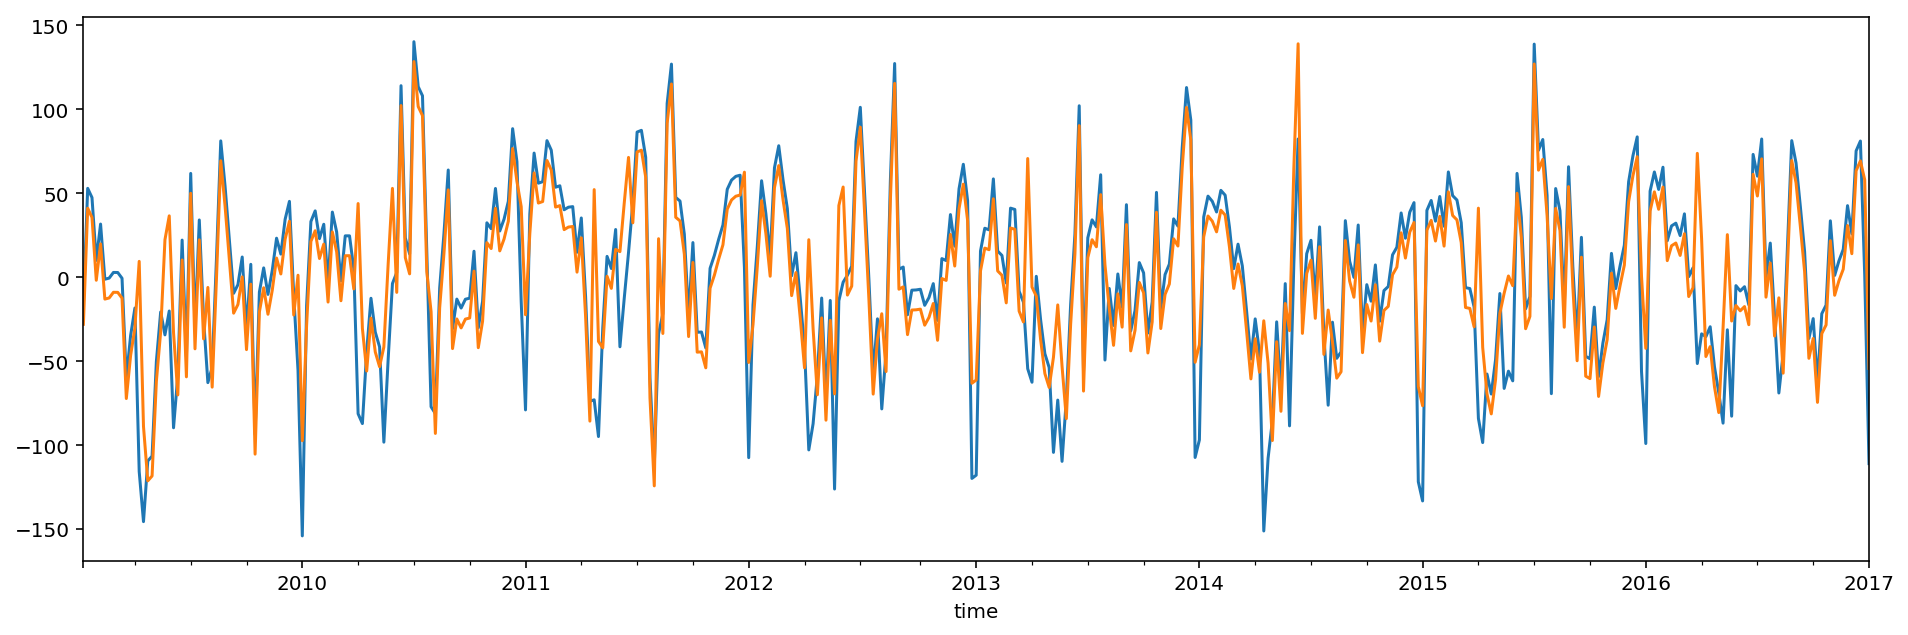

In [20]:
residual_weather.plot()
res_holiday_crude.plot()

In [21]:
(residual_weather**2).mean() #MSE of regression on weather

2804.450767727304

In [22]:
(res_holiday_crude**2).mean() # MSE after controlling for holidays

1954.1578830819863

### Finer holiday counting

Let's define a covariate that counts canton per canton the number of residents that are on holiday, and then aggregate over all switzerland

In [23]:
def get_holy(prov):
    h = holidays.Switzerland(prov=prov)
    return [day in h for day in days]
holidays_cantons = pd.DataFrame(data = {prov:get_holy(prov) for prov in holidays.Switzerland.PROVINCES},
             index = days)
#add sundays (hurts MSE)
# holidays_cantons = (holidays_cantons.T | (holidays_cantons.index.dayofweek == 6)).T

In [24]:
cantons = pd.read_csv('cantons.csv').set_index('Code')
#magic trick
cantons['Population'] = cantons['Population'].str.extract('([^\[]*)').iloc[:,0].str.split(',').str.join('').astype(np.intp)

In [25]:
holiday_pop = (holidays_cantons*cantons['Population']
              ).resample(
    'W'
    ).mean().sum(1)[residual_weather.index[0]:residual_weather.index[-1]]

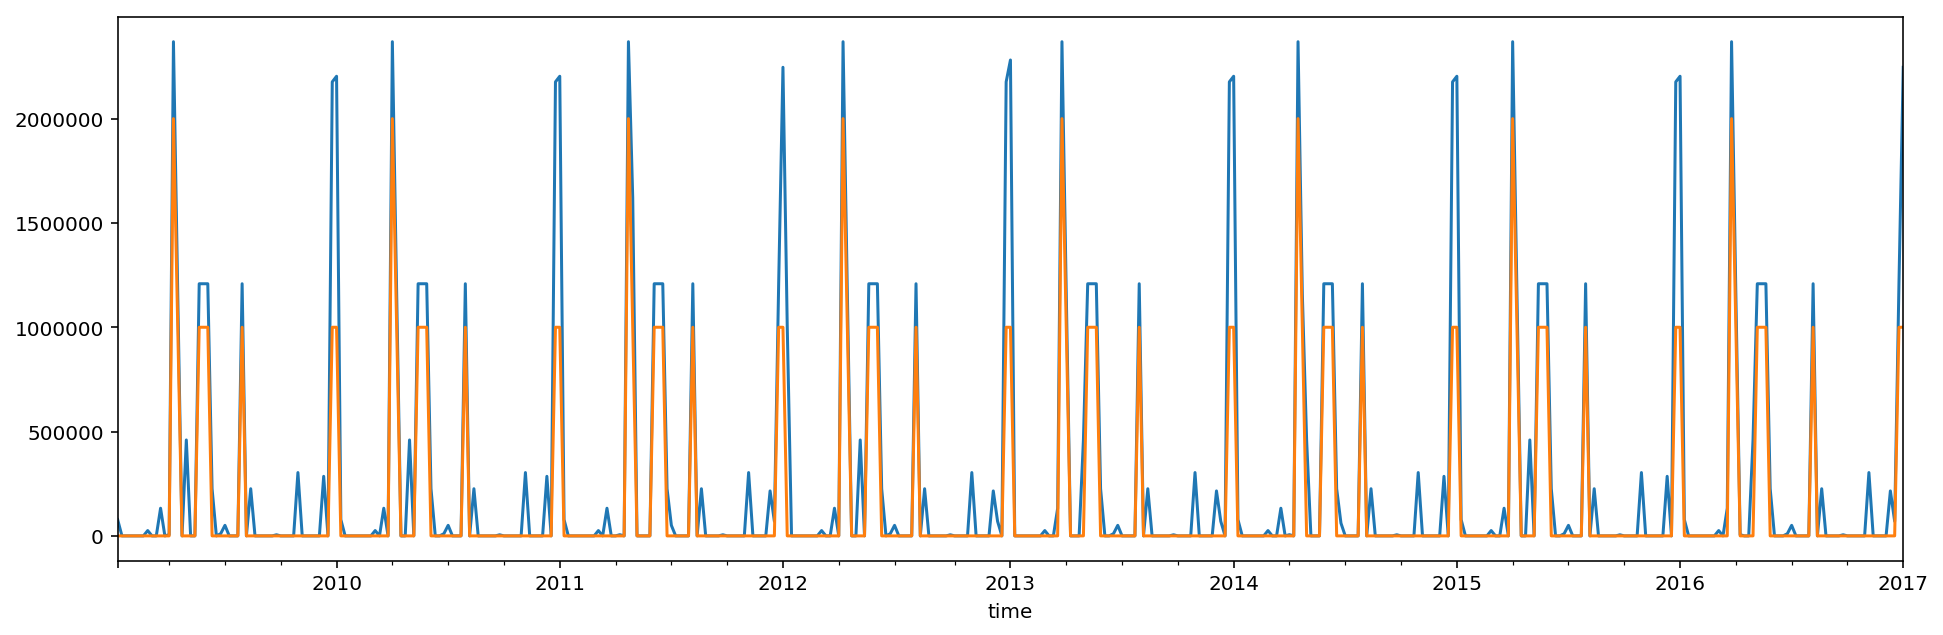

In [26]:
holiday_pop.plot()
(h_reg*1e6).plot() #rescale the crude regressor since it only counts the number of 
                    # festifities and not the total people subject

Extra days appear with this finer approach, lets check if it makes a difference

In [27]:
holiday_fine_model = LinearRegression().fit(holiday_pop.values.reshape(-1,1), residual_weather.values.reshape(-1,1))
res_holiday_fine = residual_weather - holiday_fine_model.predict(holiday_pop.values.reshape(-1,1)).flatten()

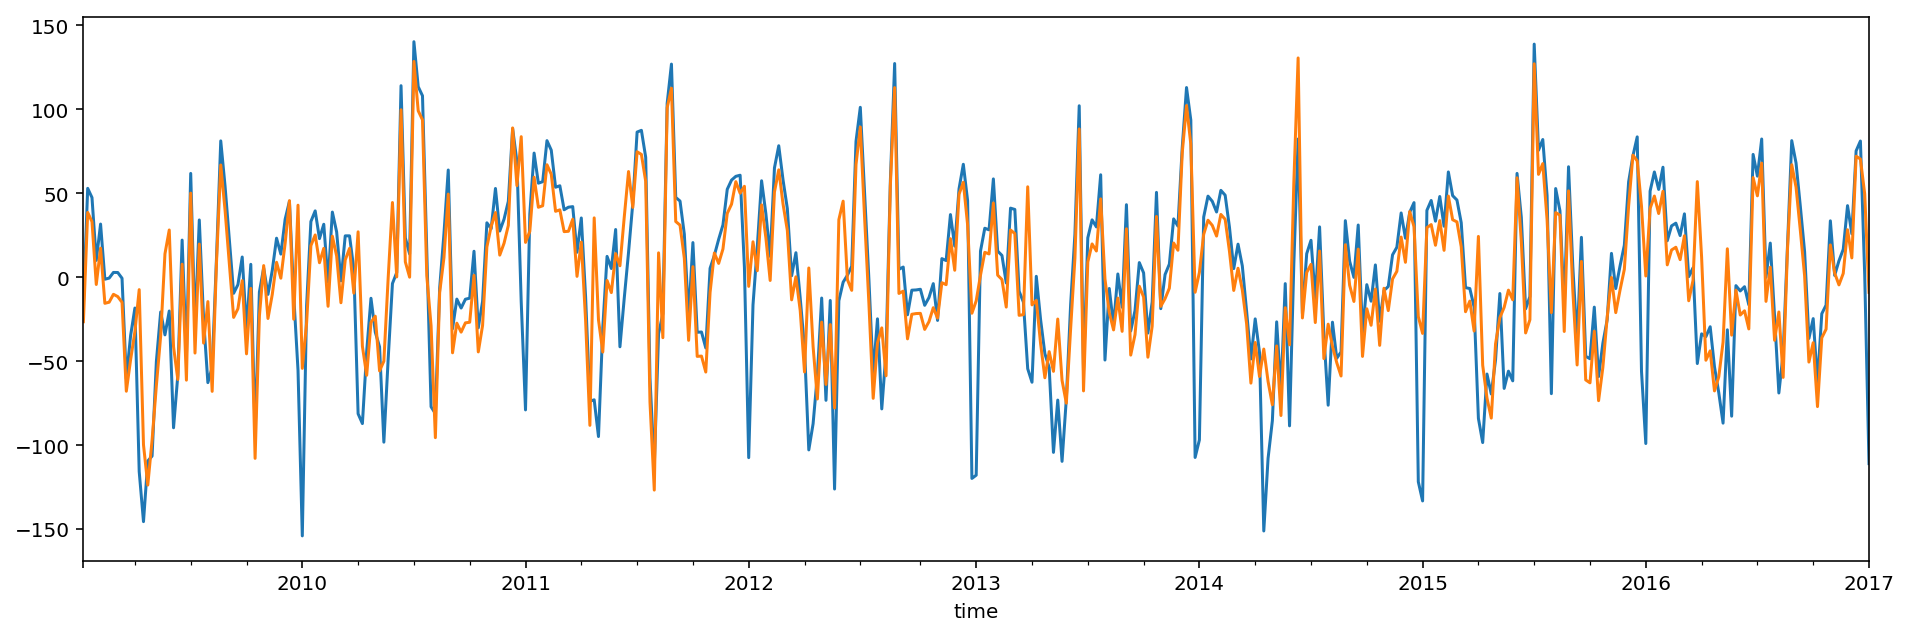

In [28]:
residual_weather.plot()
res_holiday_fine.plot()

In [29]:
(res_holiday_fine**2).mean()

1856.1445098328056

In [30]:
(res_holiday_crude**2).mean()

1954.1578830819863

MSE further increased by a bit, with the finer counting method.

### We regressed individually on weather, and then on holidays. Now we try to do them together.

In [31]:
c # consumption in GWh
holiday_pop #people days of holiday per week
w #average temperature deviation(?) per week

data = pd.DataFrame({'temp':w['CH_temperature'], 'consumption':c, 'holidays':holiday_pop})
# data['cross'] = data['temp']*data['holidays'] cross term useless
weather_holiday_model = LinearRegression().fit(data[['temp','holidays']].values, data[['consumption']])

In [32]:
est_weather_holiday = pd.Series(weather_holiday_model.predict(data[['temp', 'holidays']].values).flatten(), data.index)

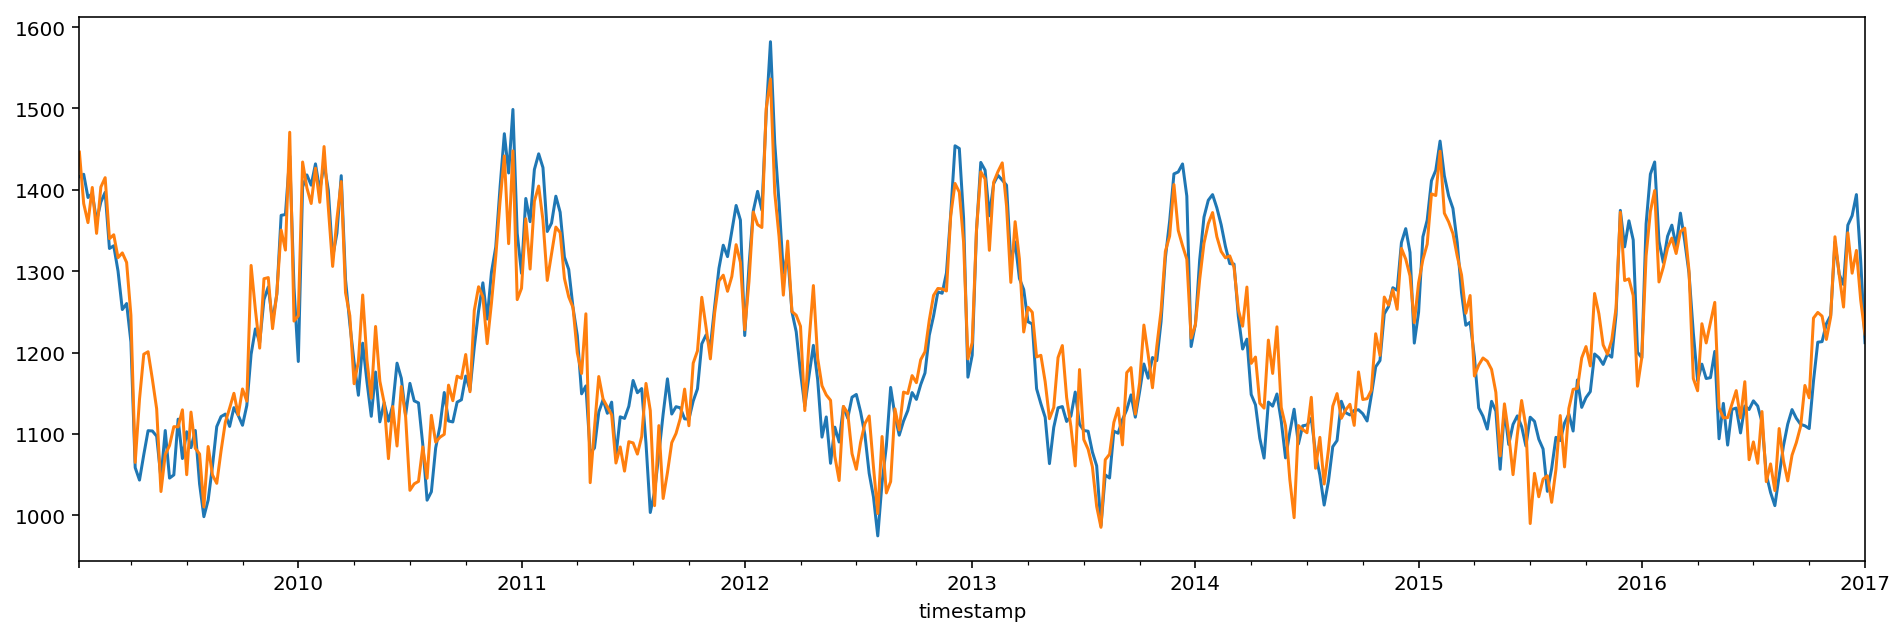

In [33]:
c.plot()
est_weather_holiday.plot()

In [34]:
res_weather_holiday = c-est_weather_holiday
(res_weather_holiday**2).mean()

1853.0028145097185

Almost the same as first regressing on weather and then on holidays

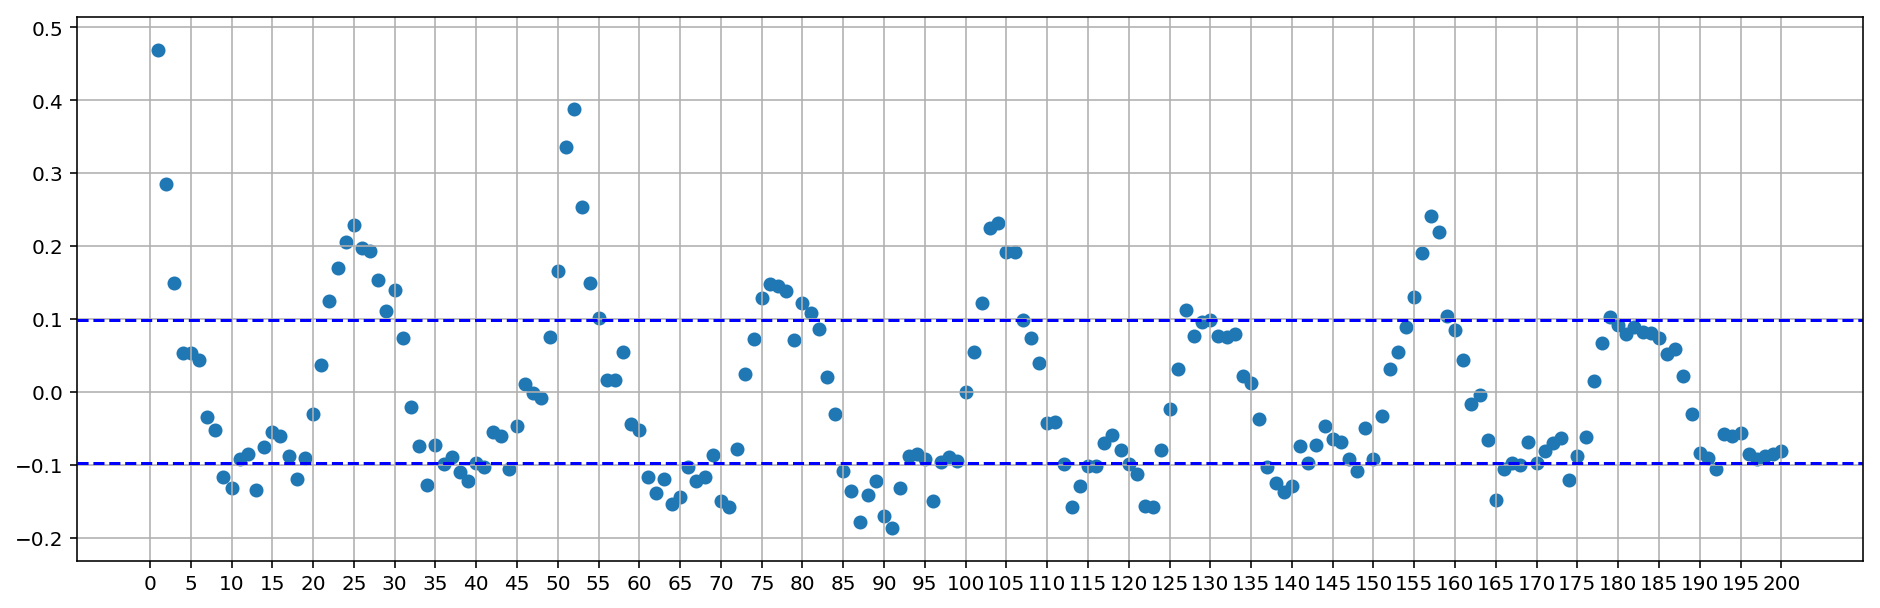

In [35]:
acf(res_weather_holiday,200) # what does this acf mean for residuals? definitely not random

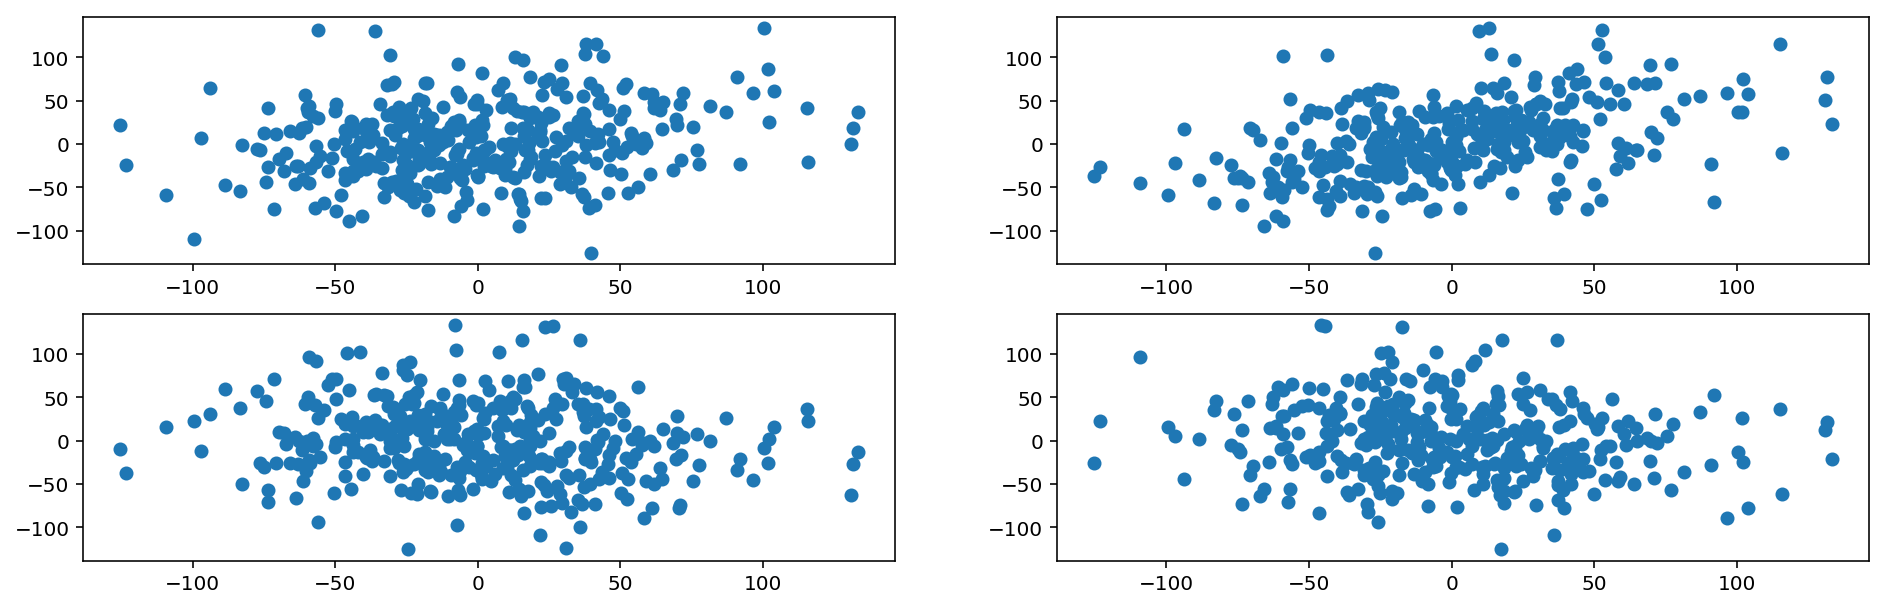

In [36]:
plt.subplot(2,2,1)
plt.scatter(res_weather_holiday[:-26], res_weather_holiday[26:])
plt.subplot(2,2,2)
plt.scatter(res_weather_holiday[:-52], res_weather_holiday[52:])
plt.subplot(2,2,3)
plt.scatter(res_weather_holiday[:-13], res_weather_holiday[13:])
plt.subplot(2,2,4)
plt.scatter(res_weather_holiday[:-39], res_weather_holiday[39:])

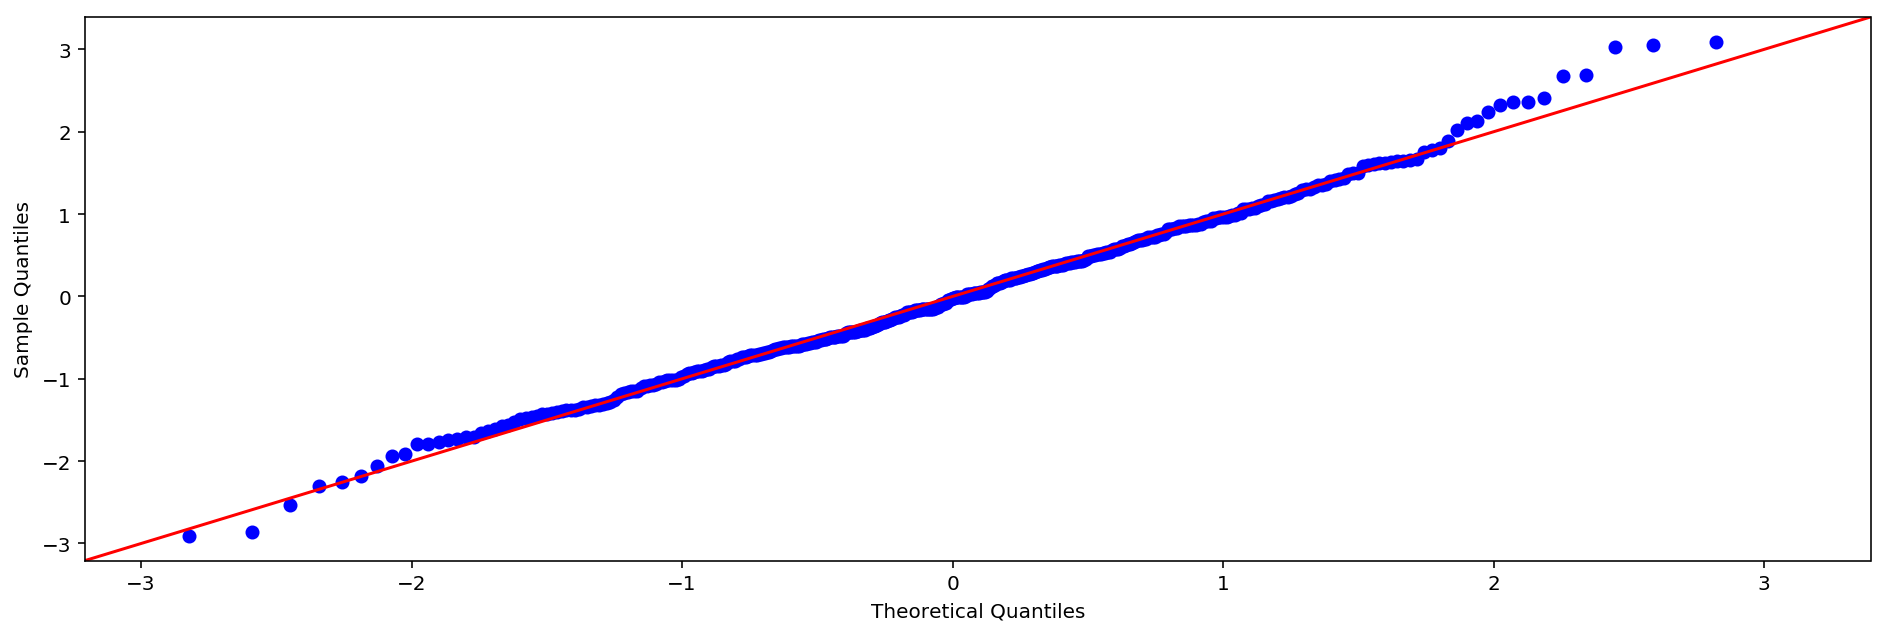

In [37]:
sm.qqplot(res_weather_holiday/res_weather_holiday.std());
sm.qqline(plt.gca(),'45')
# very nice qqplot

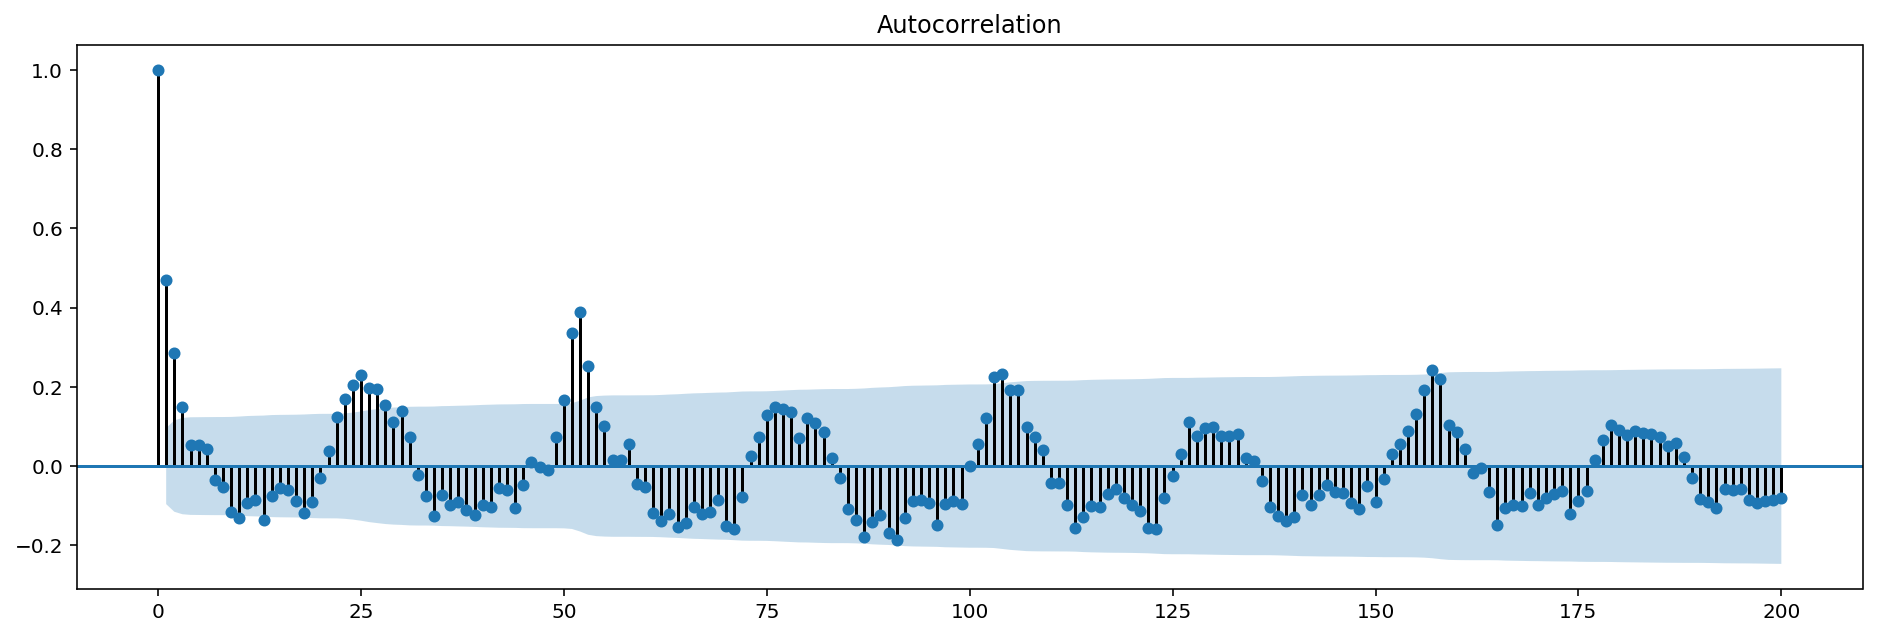

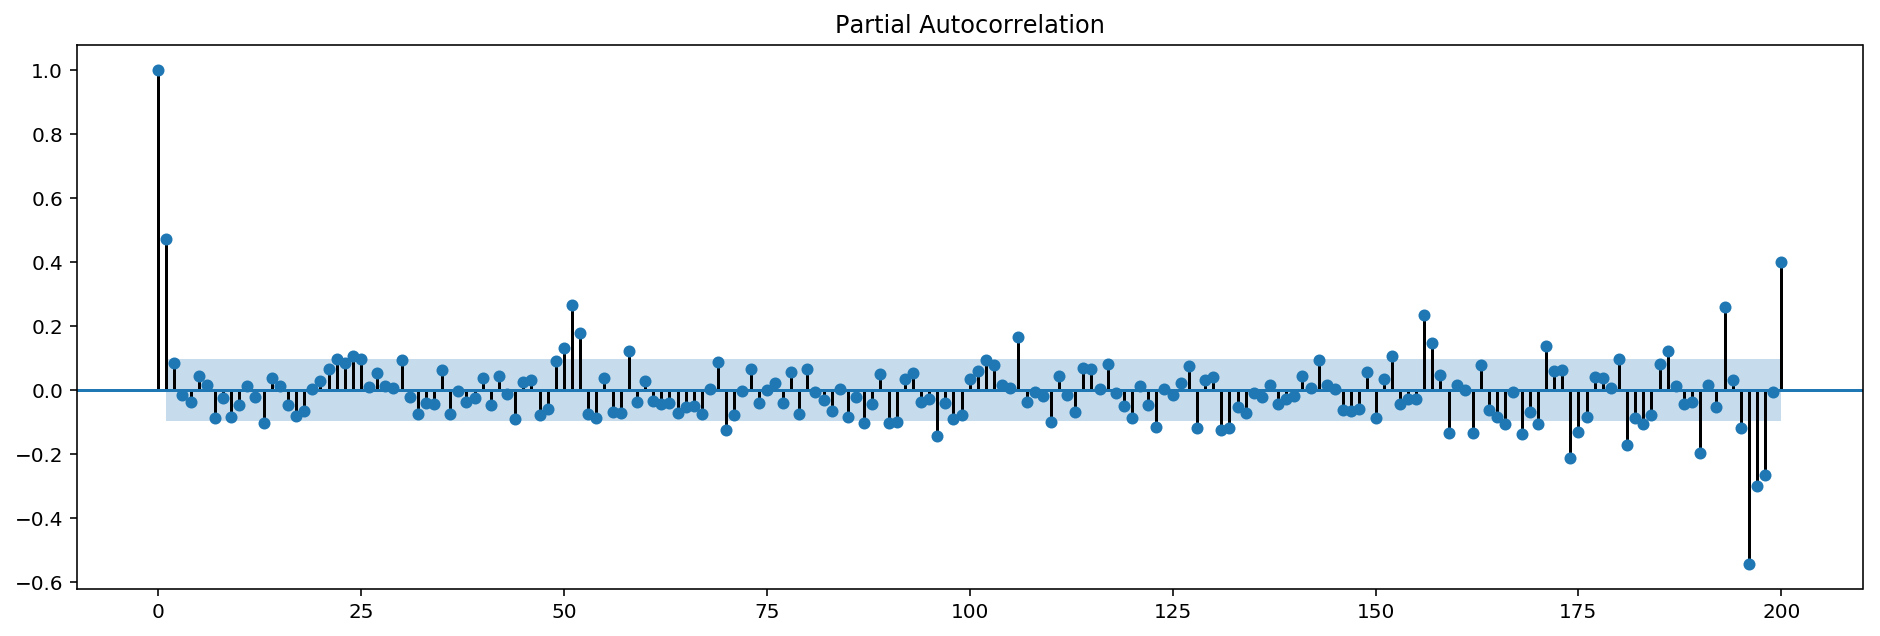

In [227]:
plot_acf(res_weather_holiday,lags=200);
plot_pacf(res_weather_holiday,lags=200);

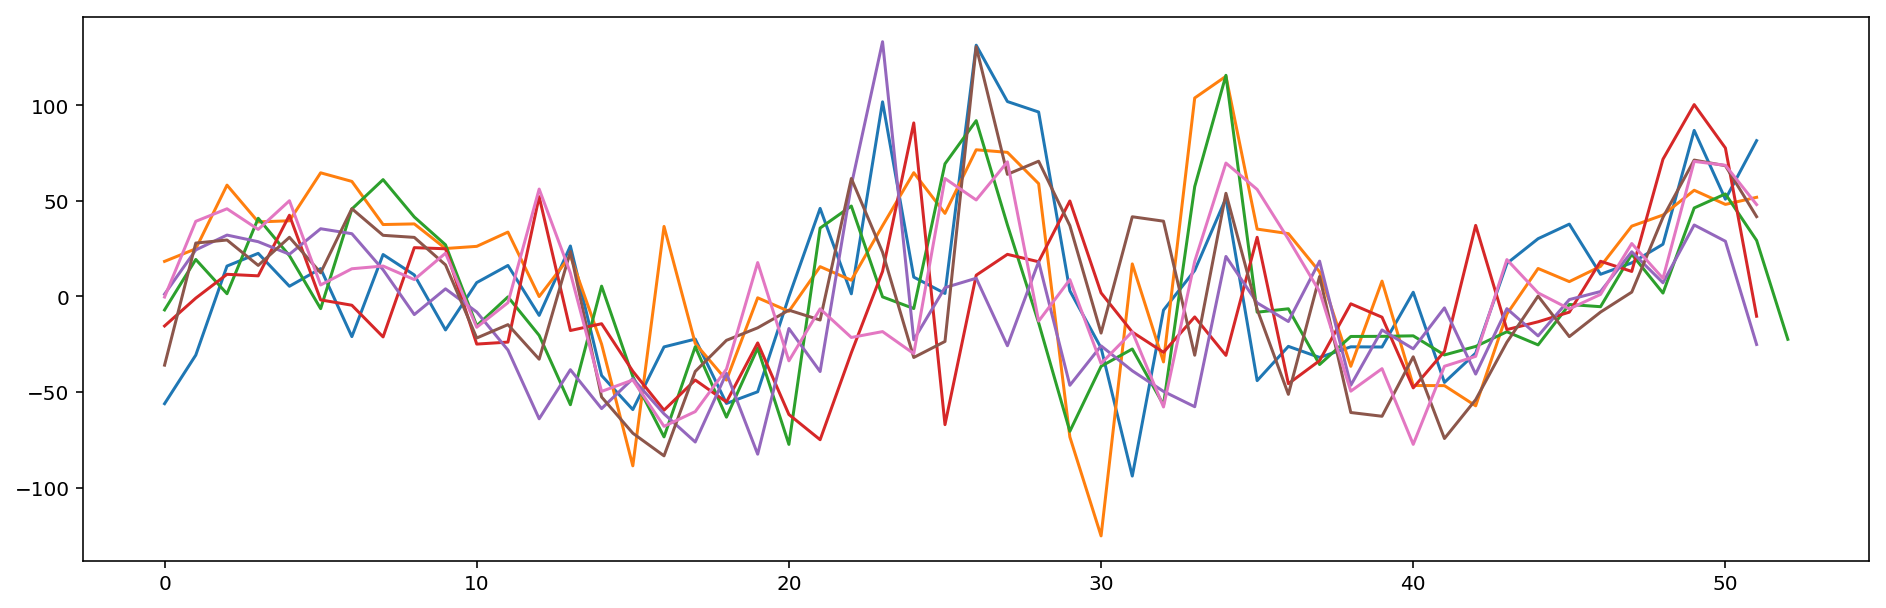

In [39]:
[plt.plot(res_weather_holiday[str(year)].values) for year in range(2010,2017)];
#error not only has variable volatility but also a trend

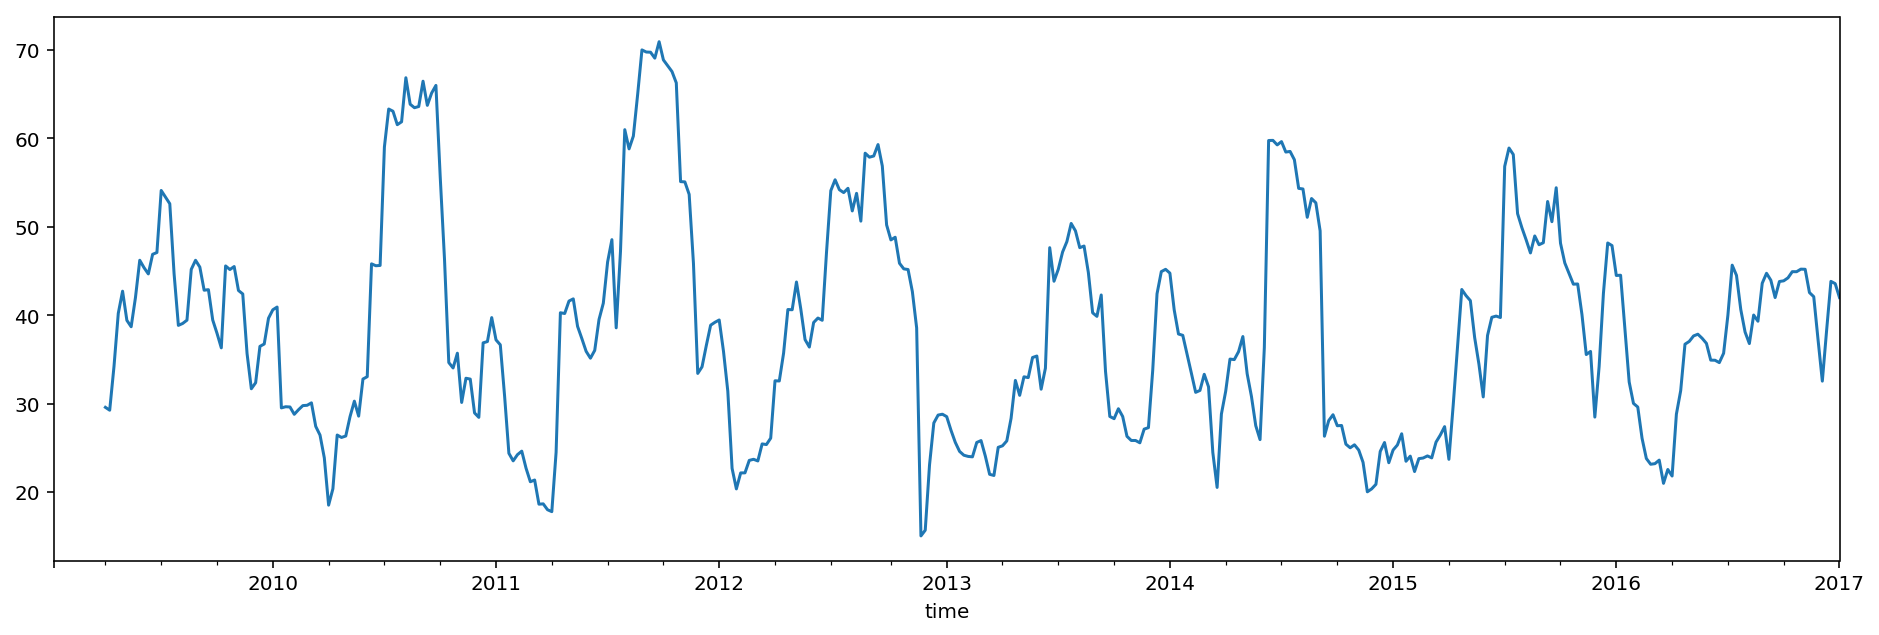

In [40]:
res_weather_holiday.rolling(13).std().plot()

## Further developments: STL on residuals / filtering on STL residuals

In [42]:
import stldecompose

In [71]:
b = stldecompose.decompose(res_weather_holiday, period=52, lo_delta=1);

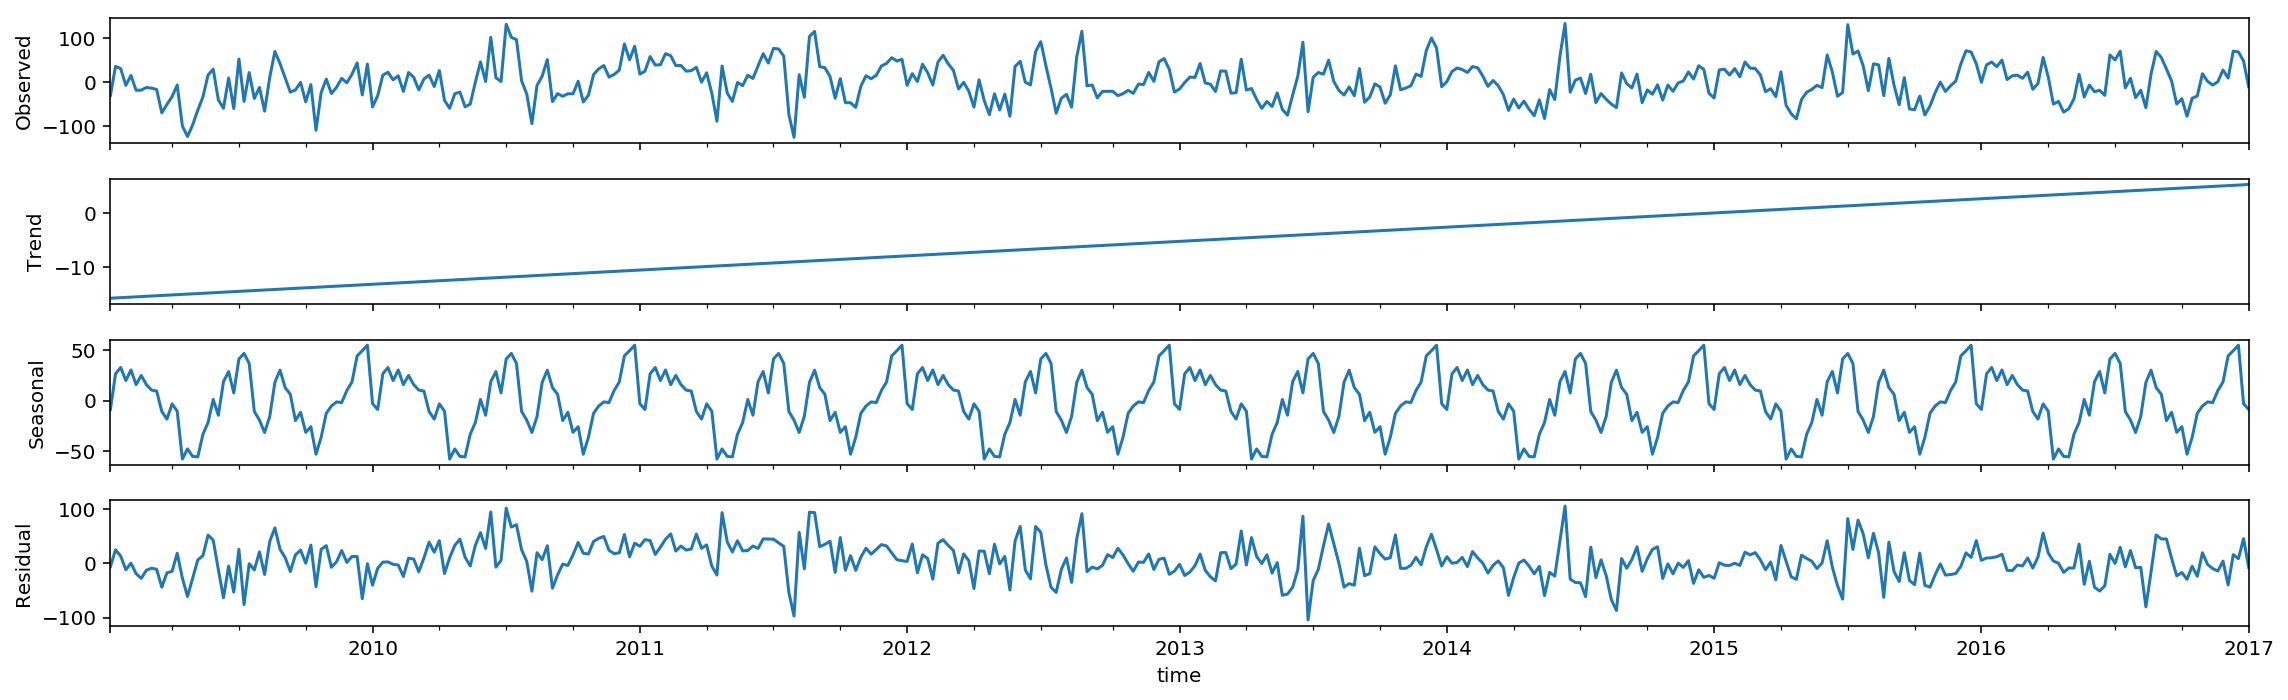

In [73]:
b.plot();

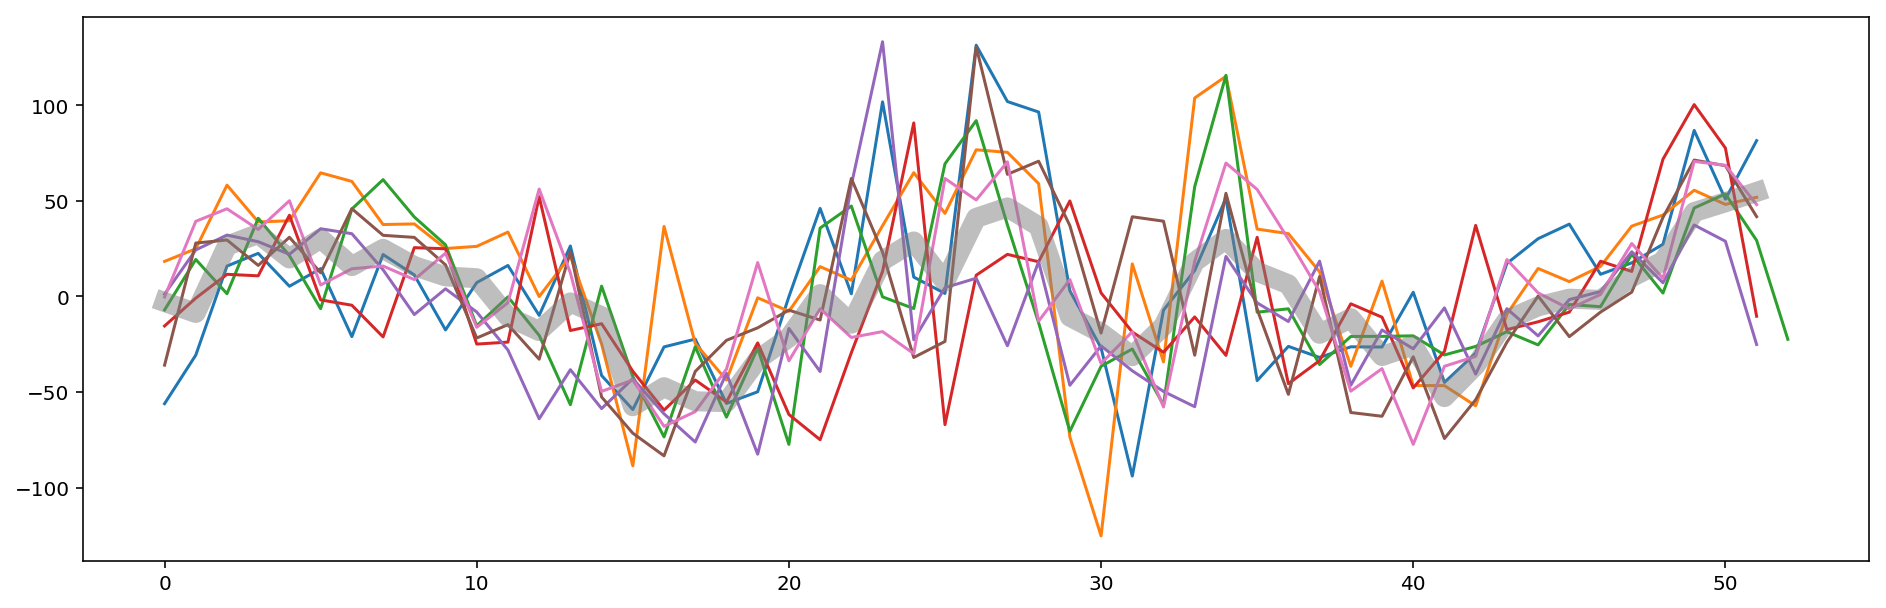

In [78]:
[plt.plot(res_weather_holiday[str(year)].values) for year in range(2010,2017)];
plt.plot(b.seasonal['2010'].values, linewidth=10, alpha=0.5)

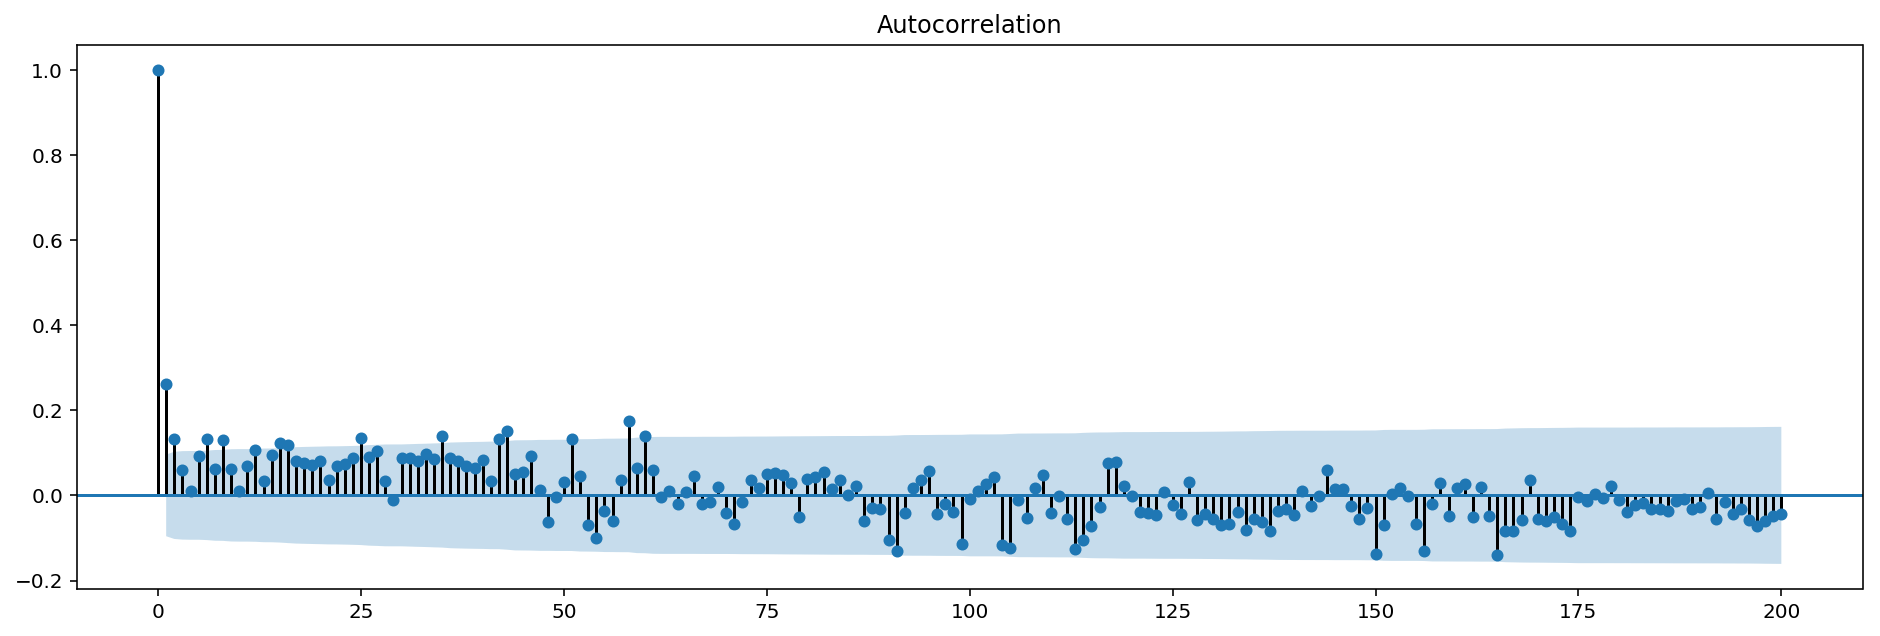

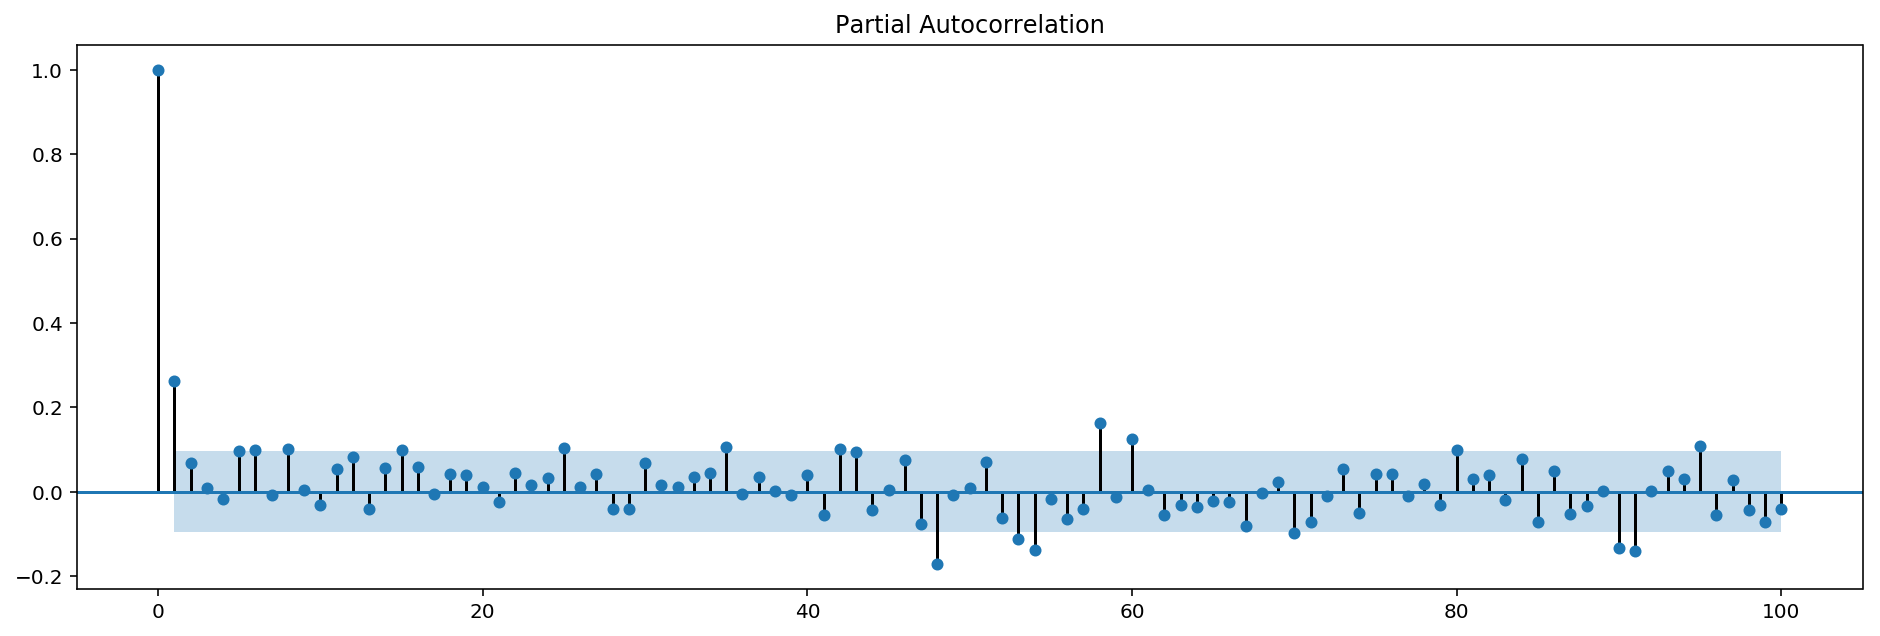

In [87]:
plot_acf(b.resid, lags=200);
plot_pacf(b.resid, lags=100);

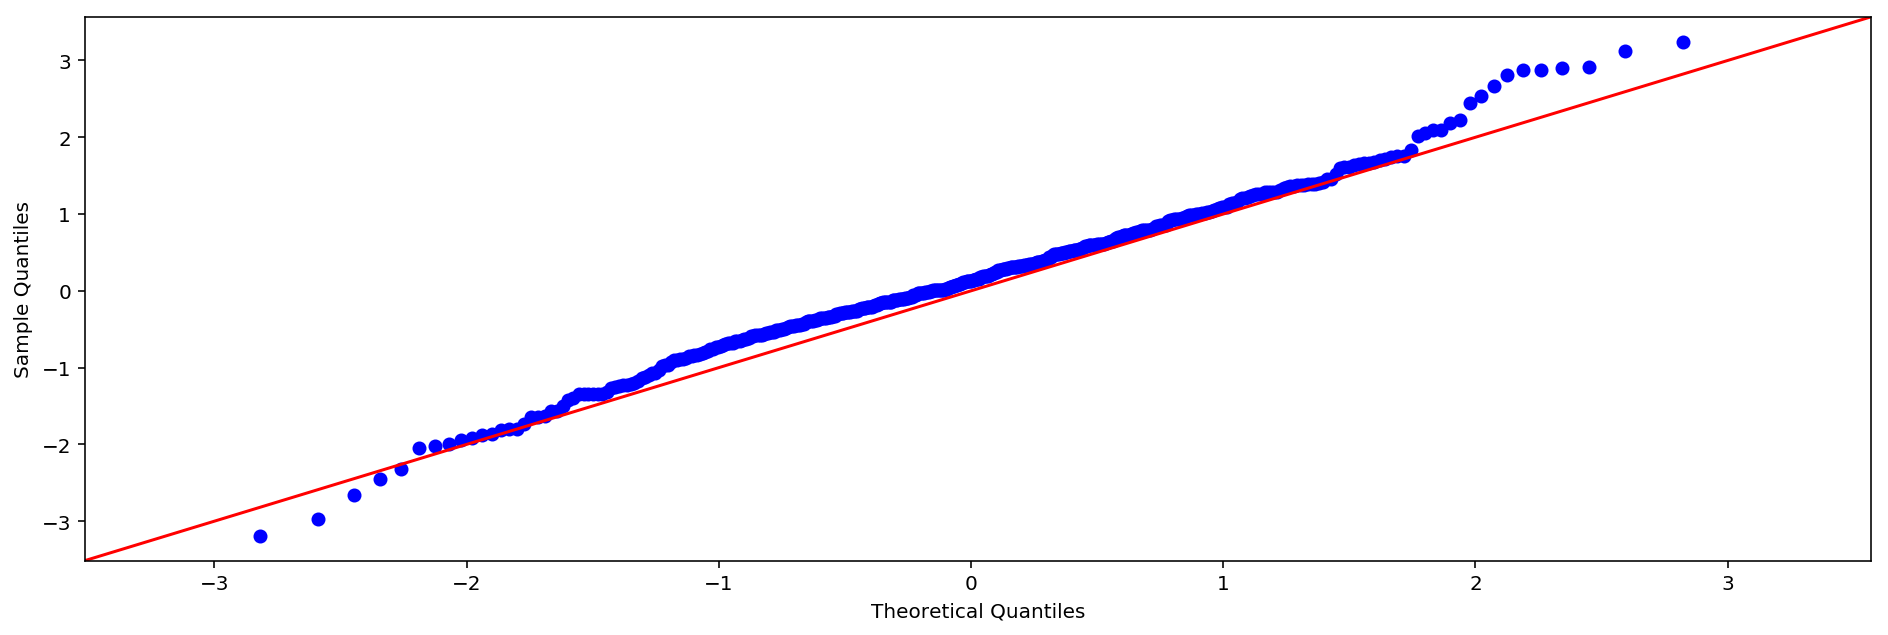

In [100]:
sm.qqplot(b.resid/b.resid.std())
sm.qqline(plt.gca(), '45')

In [190]:
sm.tsa.kpss(b.resid, regression='c')

(0.6050220417232657,
 0.022179814388794027,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

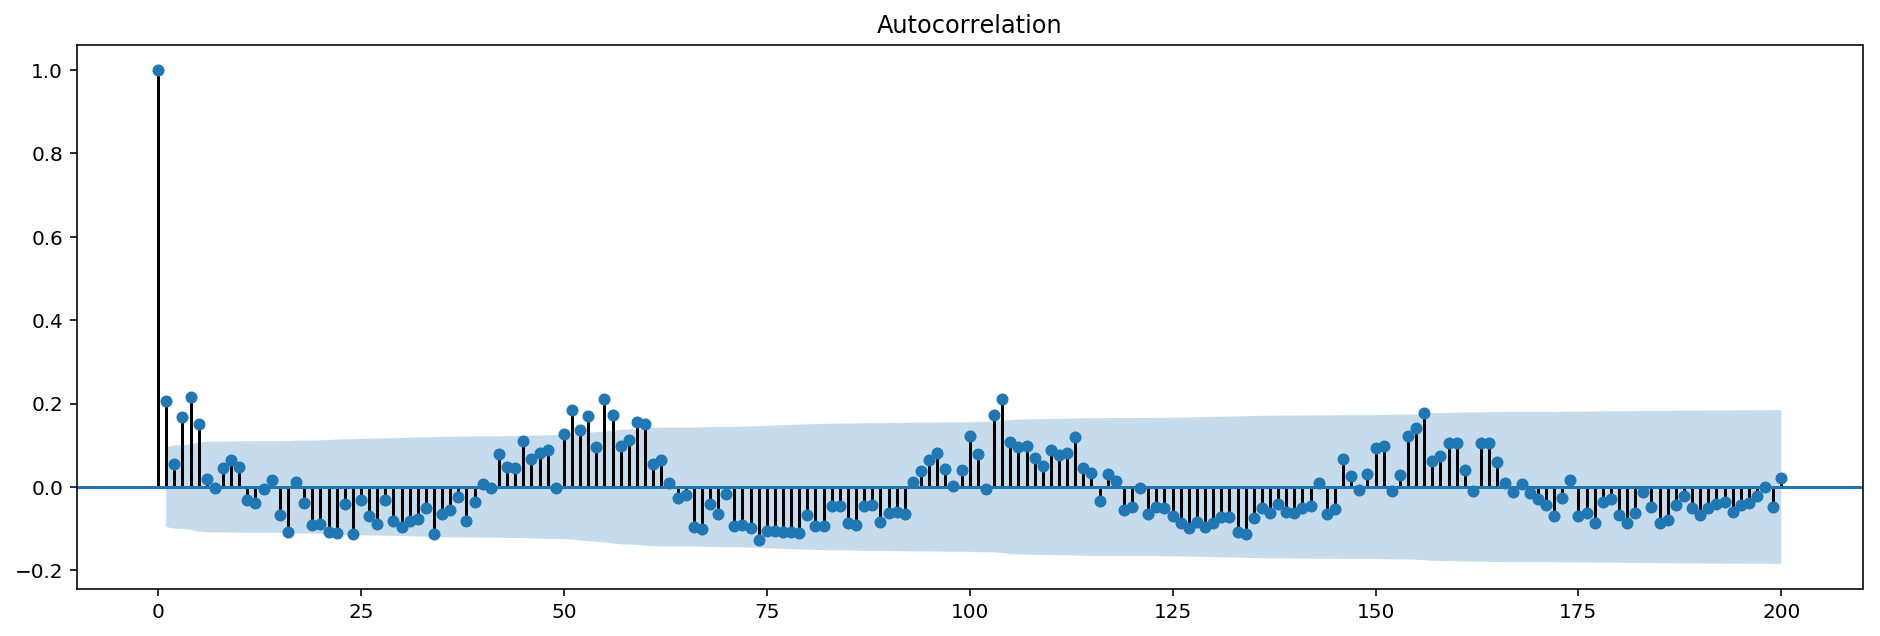

In [98]:
plot_acf(b.resid**2, lags=200);

In [283]:
ima1 = sm.tsa.ARIMA(b.resid,order=(0,1,1)).fit(trend='nc')
arima11 = sm.tsa.ARIMA(b.resid,order=(1,1,1)).fit(trend='nc')
sarima111x011 = sm.tsa.SARIMAX(b.resid,order=(1,1,1), seasonal_order=(0,1,1,52)).fit()

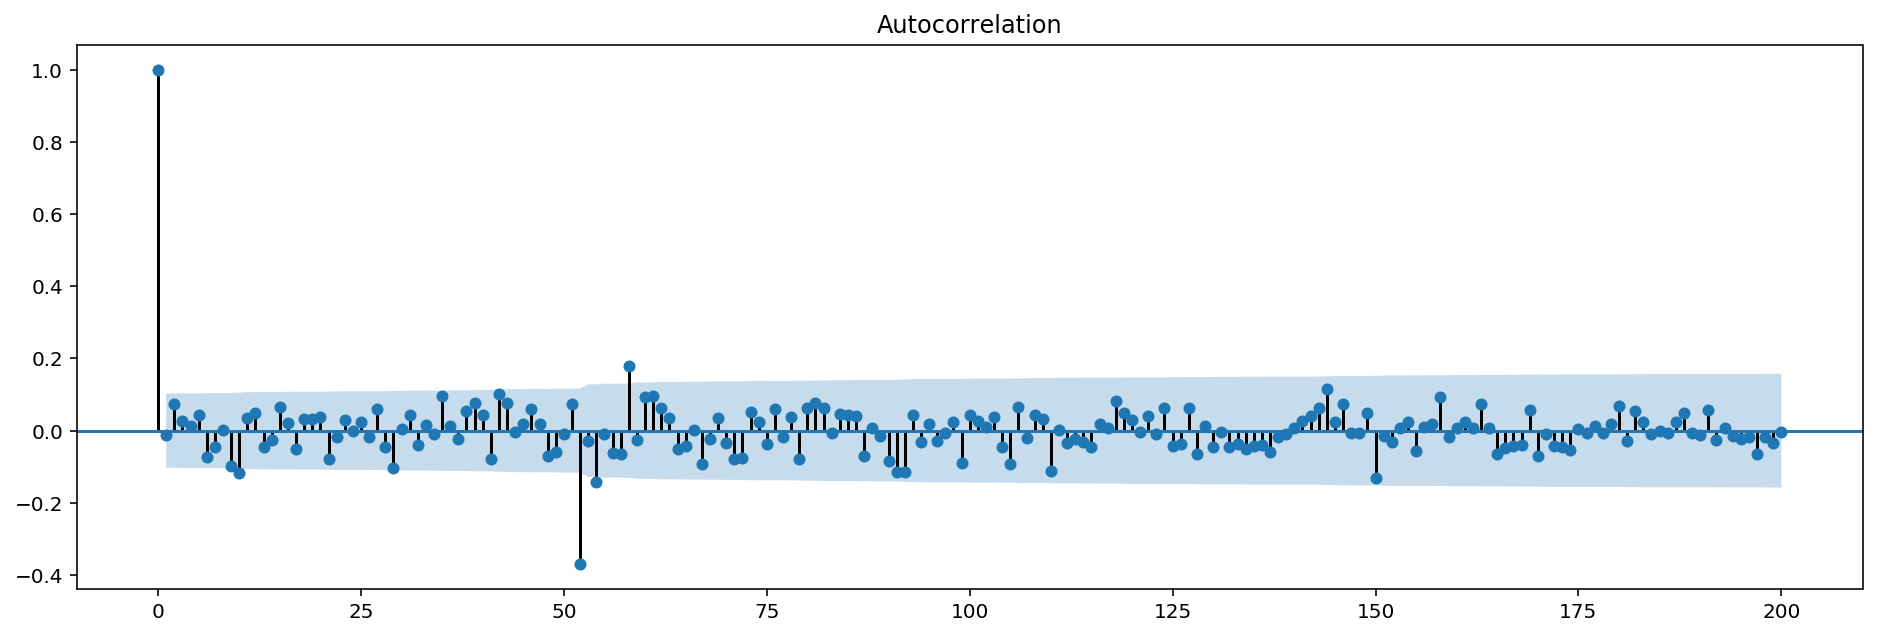

In [284]:
plot_acf(arima11.resid.diff(52).dropna(),lags=200);

In [285]:
sarima111x011.conf_int()

,0,1
ar.L1,0.104141,0.265397
ma.L1,-0.990141,-0.925720
ma.S.L52,-0.833353,-0.614510
sigma2,1166.747892,1480.800420


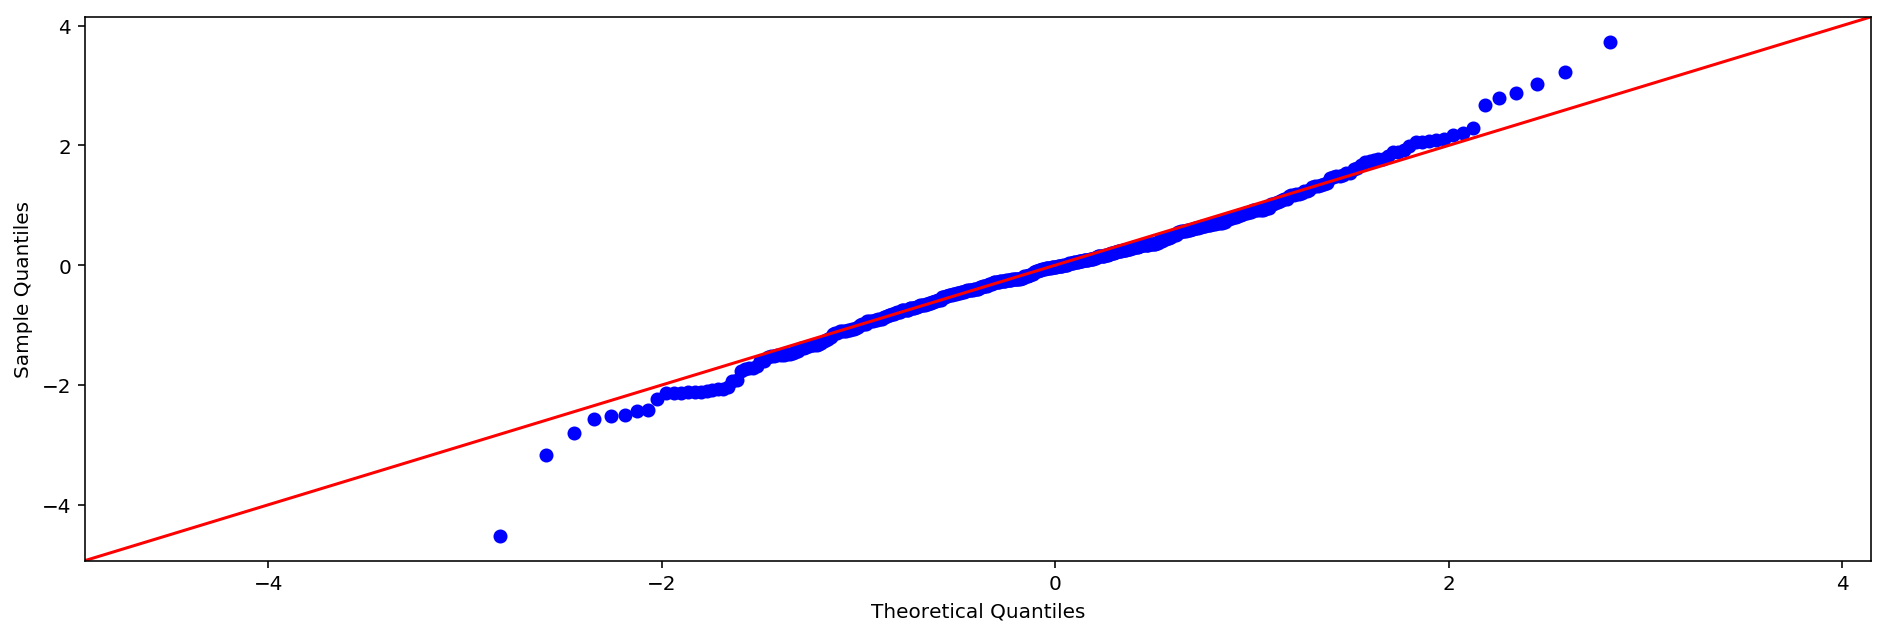

In [287]:
sm.qqplot(sarima111x011.resid/np.sqrt(sarima111x011.params.sigma2));
sm.qqline(plt.gca(),'45')

In [288]:
sarima111x011.aic

3697.9279207792074

In [289]:
ima1.aic

4060.715389289425

In [290]:
arima11.aic

4049.2226009240194

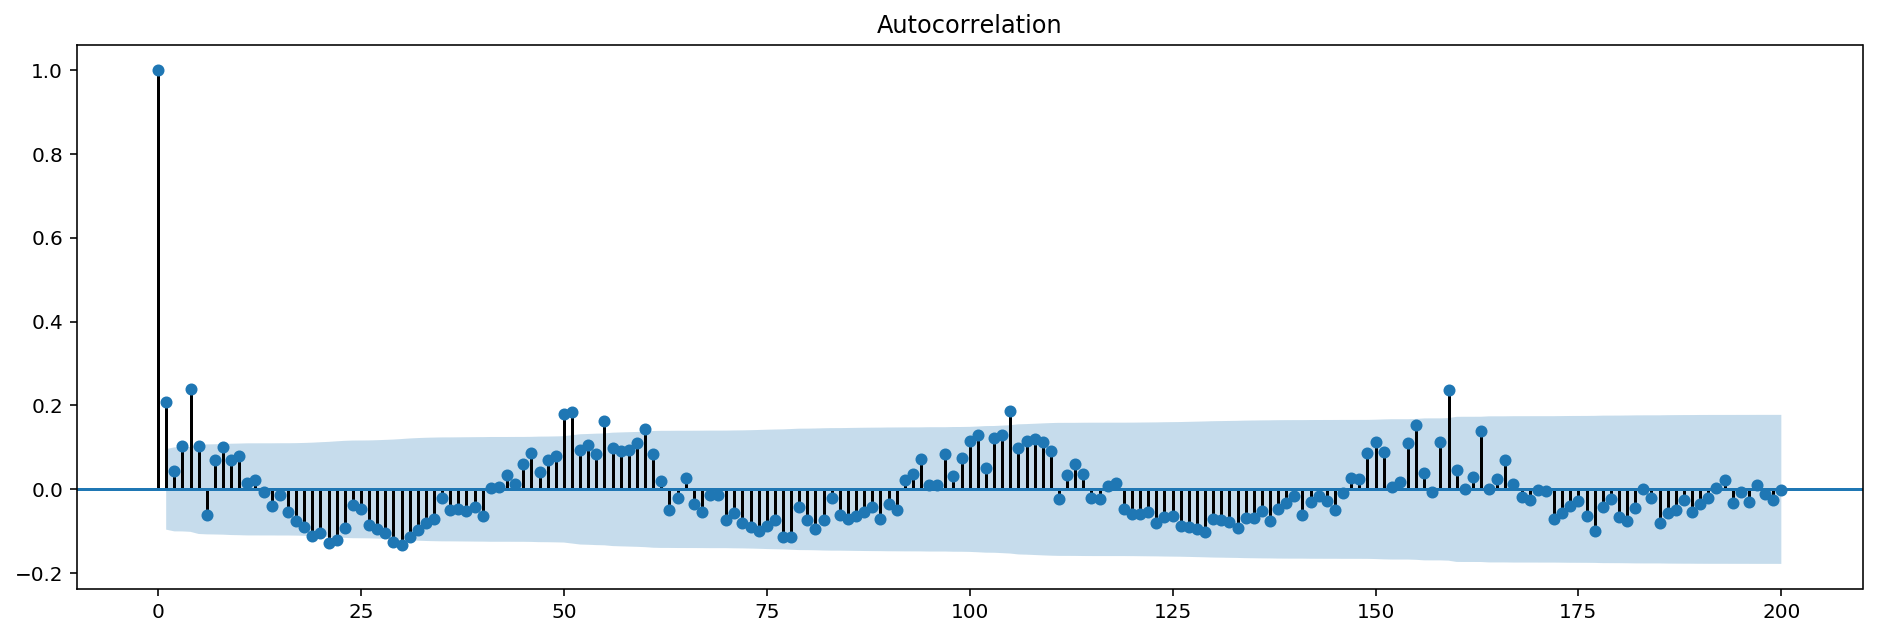

In [293]:
plot_acf(sarima111x011.resid.pow(2), lags=200);